In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
BATCH_SIZE = 128
LATENT_DIM = 2  # 2D for visualization
HIDDEN_DIM = 400
LEARNING_RATE = 1e-3
EPOCHS = 20
INPUT_DIM = 784  # 28x28

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, INPUT_DIM))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, INPUT_DIM), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

In [7]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [10]:
print("\n" + "="*50)
print("TRAINING VAE")
print("="*50)

train_losses = []
test_losses = []
recon_losses = []
kl_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    recon_loss_epoch = 0
    kl_loss_epoch = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = vae_loss(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        recon_loss_epoch += bce.item()
        kl_loss_epoch += kld.item()
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = recon_loss_epoch / len(train_loader.dataset)
    avg_kl_loss = kl_loss_epoch / len(train_loader.dataset)
    
    train_losses.append(avg_train_loss)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(avg_kl_loss)
    
    # Test
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, _, _ = vae_loss(recon_batch, data, mu, logvar)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Recon: {avg_recon_loss:.4f} | KL: {avg_kl_loss:.4f}')



TRAINING VAE
Epoch 1/20 | Train Loss: 182.8419 | Test Loss: 164.6434 | Recon: 178.7091 | KL: 4.1328
Epoch 2/20 | Train Loss: 160.1884 | Test Loss: 157.2355 | Recon: 154.8921 | KL: 5.2963
Epoch 3/20 | Train Loss: 154.2033 | Test Loss: 152.5779 | Recon: 148.5141 | KL: 5.6892
Epoch 4/20 | Train Loss: 150.8455 | Test Loss: 149.9974 | Recon: 144.9646 | KL: 5.8808
Epoch 5/20 | Train Loss: 148.8365 | Test Loss: 148.1645 | Recon: 142.8090 | KL: 6.0276
Epoch 6/20 | Train Loss: 147.2323 | Test Loss: 147.3666 | Recon: 141.1172 | KL: 6.1152
Epoch 7/20 | Train Loss: 145.9020 | Test Loss: 146.5401 | Recon: 139.6631 | KL: 6.2389
Epoch 8/20 | Train Loss: 145.0037 | Test Loss: 145.4344 | Recon: 138.7088 | KL: 6.2949
Epoch 9/20 | Train Loss: 144.2092 | Test Loss: 144.4867 | Recon: 137.8559 | KL: 6.3532
Epoch 10/20 | Train Loss: 143.4167 | Test Loss: 143.8799 | Recon: 137.0130 | KL: 6.4037
Epoch 11/20 | Train Loss: 142.9823 | Test Loss: 143.6853 | Recon: 136.5281 | KL: 6.4542
Epoch 12/20 | Train Loss: 1

In [12]:
print("\n" + "="*50)
print("EXTRACTING LATENT REPRESENTATIONS")
print("="*50)

model.eval()
latent_vectors = []
true_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        mu, _ = model.encode(data.view(-1, INPUT_DIM))
        latent_vectors.append(mu.cpu().numpy())
        true_labels.append(labels.numpy())

latent_vectors = np.vstack(latent_vectors)
true_labels = np.concatenate(true_labels)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print("\n" + "="*50)
print("TRAINING CLASSIFIER ON LATENT SPACE")
print("="*50)

X_train, X_test, y_train, y_test = train_test_split(
    latent_vectors, true_labels, test_size=0.3, random_state=42, stratify=true_labels
)

classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nClassification Metrics on Latent Space:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


EXTRACTING LATENT REPRESENTATIONS

TRAINING CLASSIFIER ON LATENT SPACE

Classification Metrics on Latent Space:
Accuracy: 0.8023
Precision: 0.8031
Recall: 0.8023
F1-Score: 0.8023


In [13]:
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9627    0.9660    0.9643       294
           1     0.9824    0.9824    0.9824       340
           2     0.8864    0.8806    0.8835       310
           3     0.8100    0.8020    0.8060       303
           4     0.5918    0.5356    0.5623       295
           5     0.6548    0.6866    0.6703       268
           6     0.8874    0.9338    0.9100       287
           7     0.9170    0.8604    0.8878       308
           8     0.7338    0.7363    0.7350       292
           9     0.5631    0.6040    0.5828       303

    accuracy                         0.8023      3000
   macro avg     0.7989    0.7988    0.7984      3000
weighted avg     0.8031    0.8023    0.8023      3000



In [14]:
y_test_bin = label_binarize(y_test, classes=np.arange(10))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


ROC-AUC Scores per class:
Digit 0: 0.9908
Digit 1: 0.9917
Digit 2: 0.9637
Digit 3: 0.9600
Digit 4: 0.9323
Digit 5: 0.9416
Digit 6: 0.9803
Digit 7: 0.9619
Digit 8: 0.9547
Digit 9: 0.9245
Micro-average ROC-AUC: 0.9665

COMPUTING RECONSTRUCTION QUALITY METRICS
SSIM: 0.5846 ± 0.1620
PSNR: 14.96 ± 2.84 dB
MSE: 0.037596 ± 0.018532

GENERATING VISUALIZATIONS

✓ Visualization saved as 'vae_mnist_complete_analysis.png'


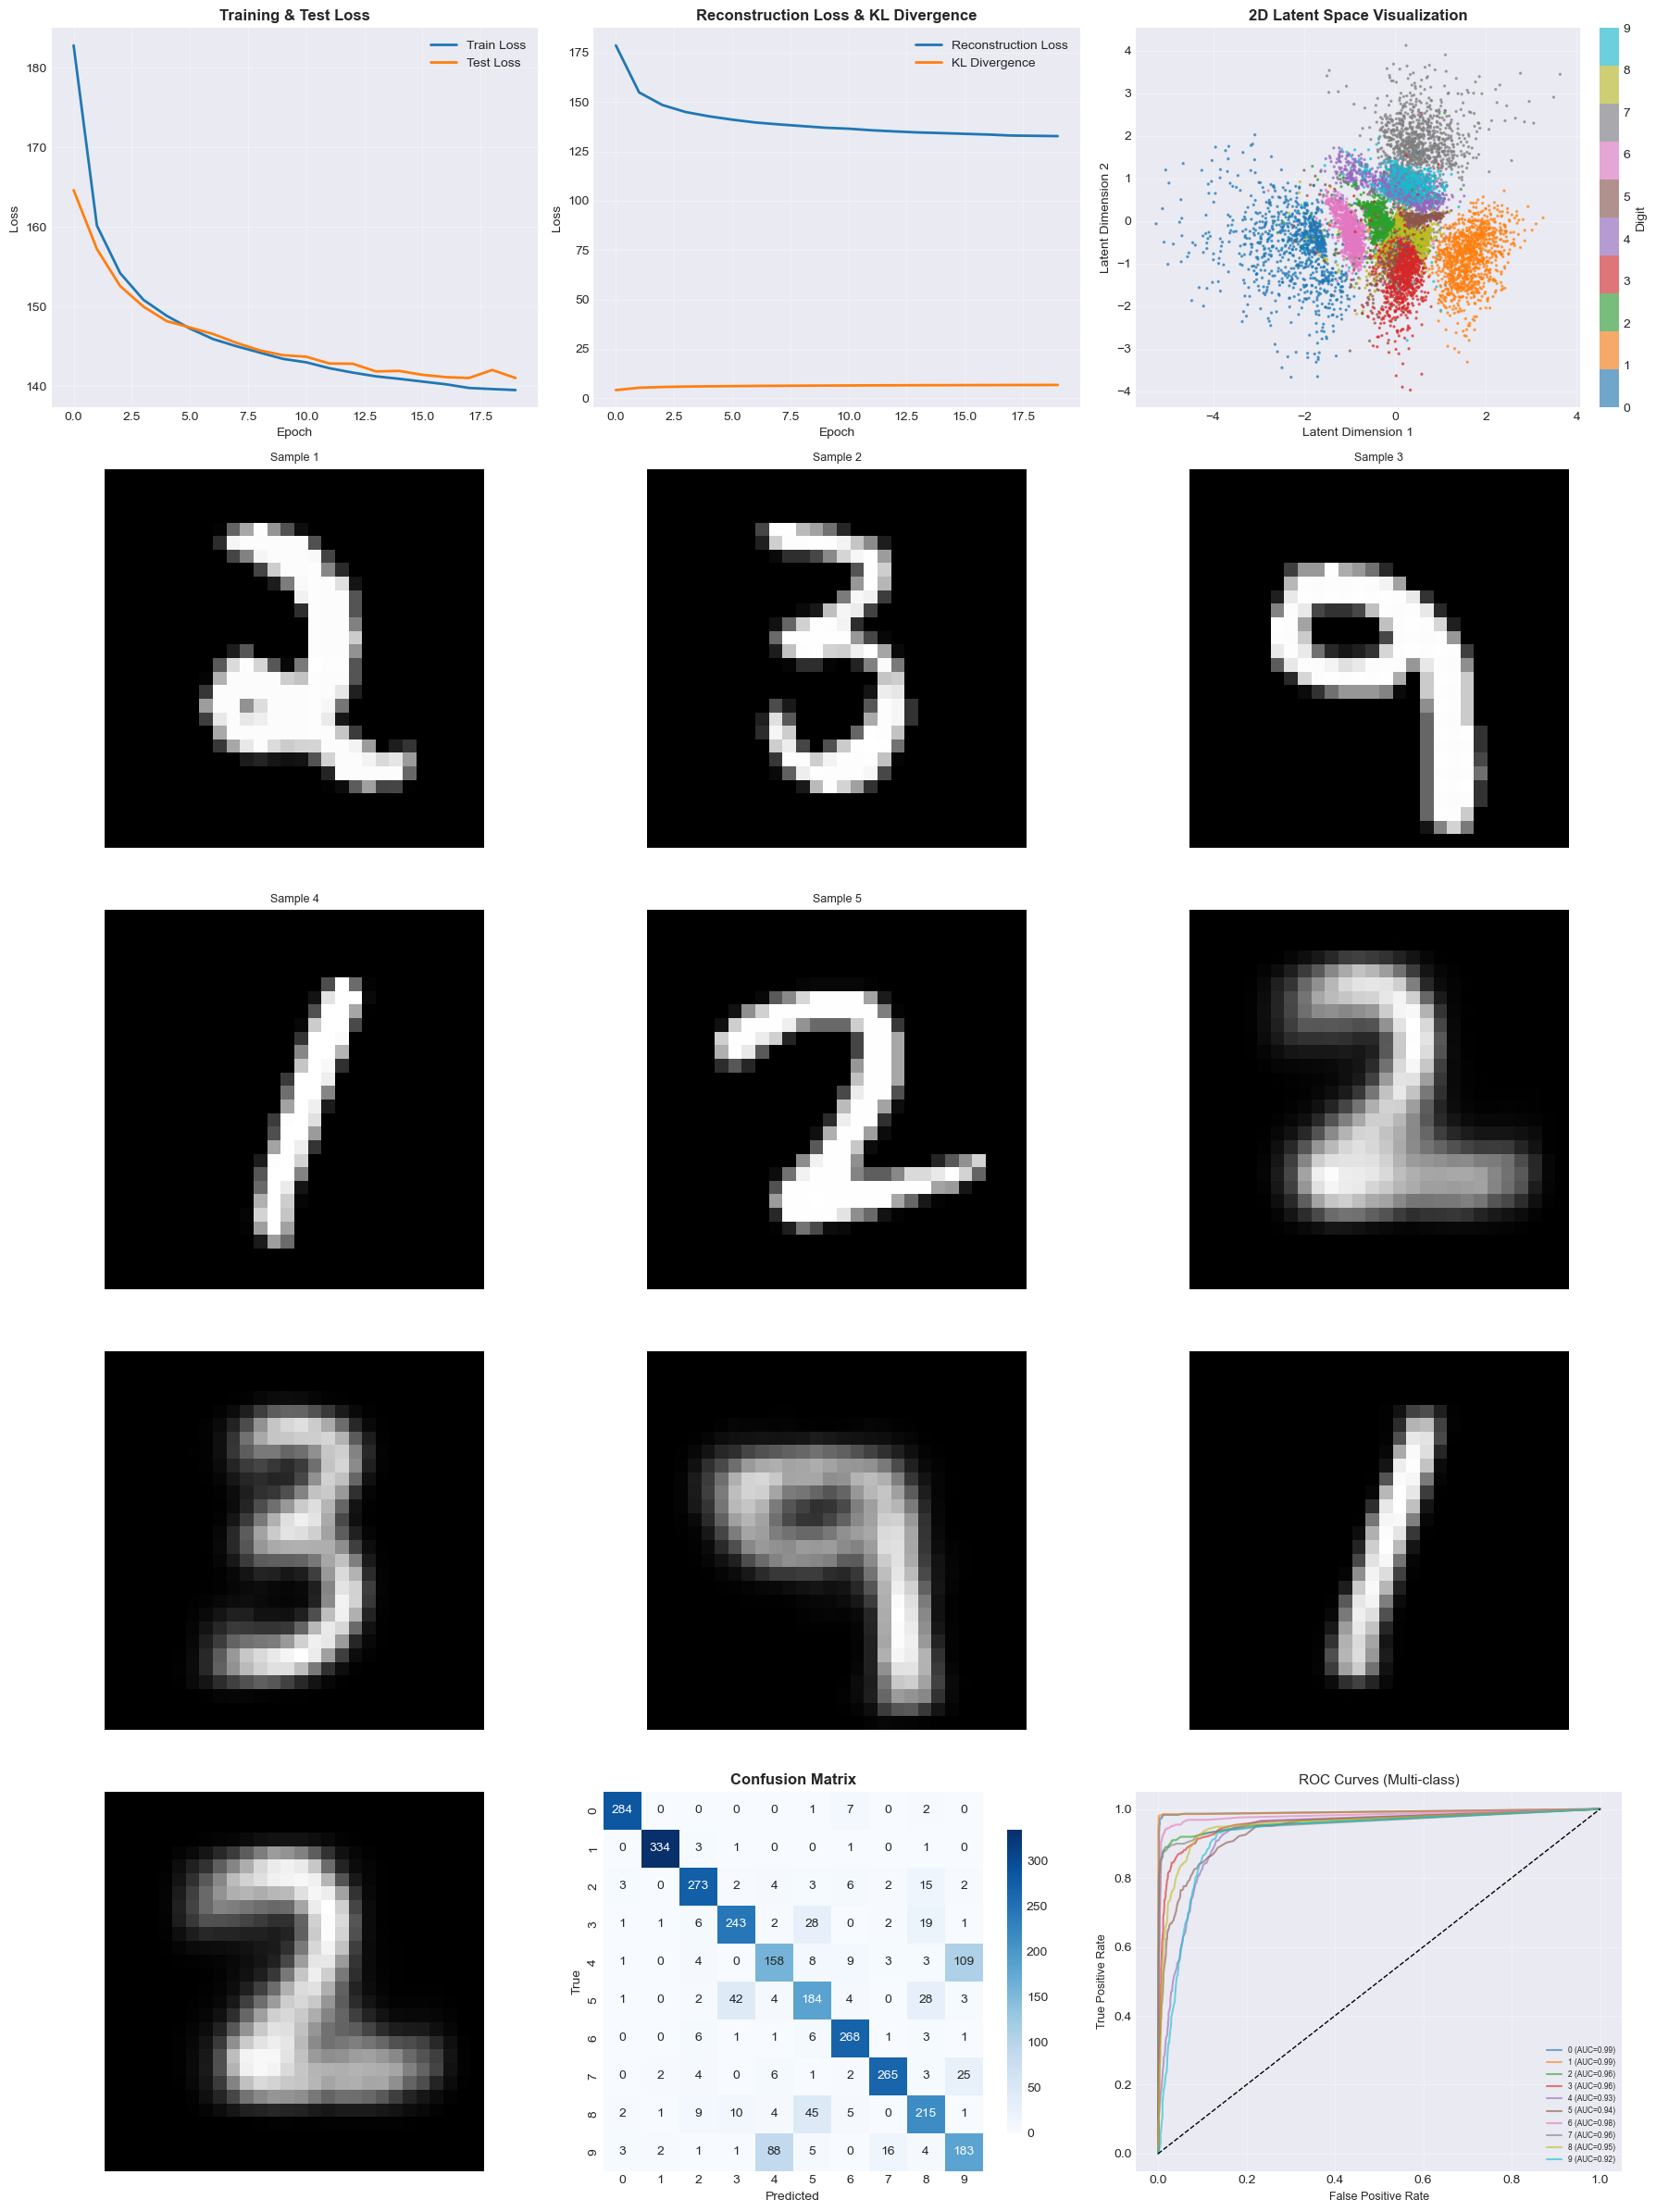

✓ Generated samples saved as 'generated_samples.png'
✓ Interpolation saved as 'interpolation.png'

✓ Reconstruction quality distributions saved as 'ssim_distribution.png' and 'psnr_distribution.png'

LATENT SPACE ANALYSIS PER DIGIT
✓ Per-digit latent space saved as 'latent_space_per_digit.png'


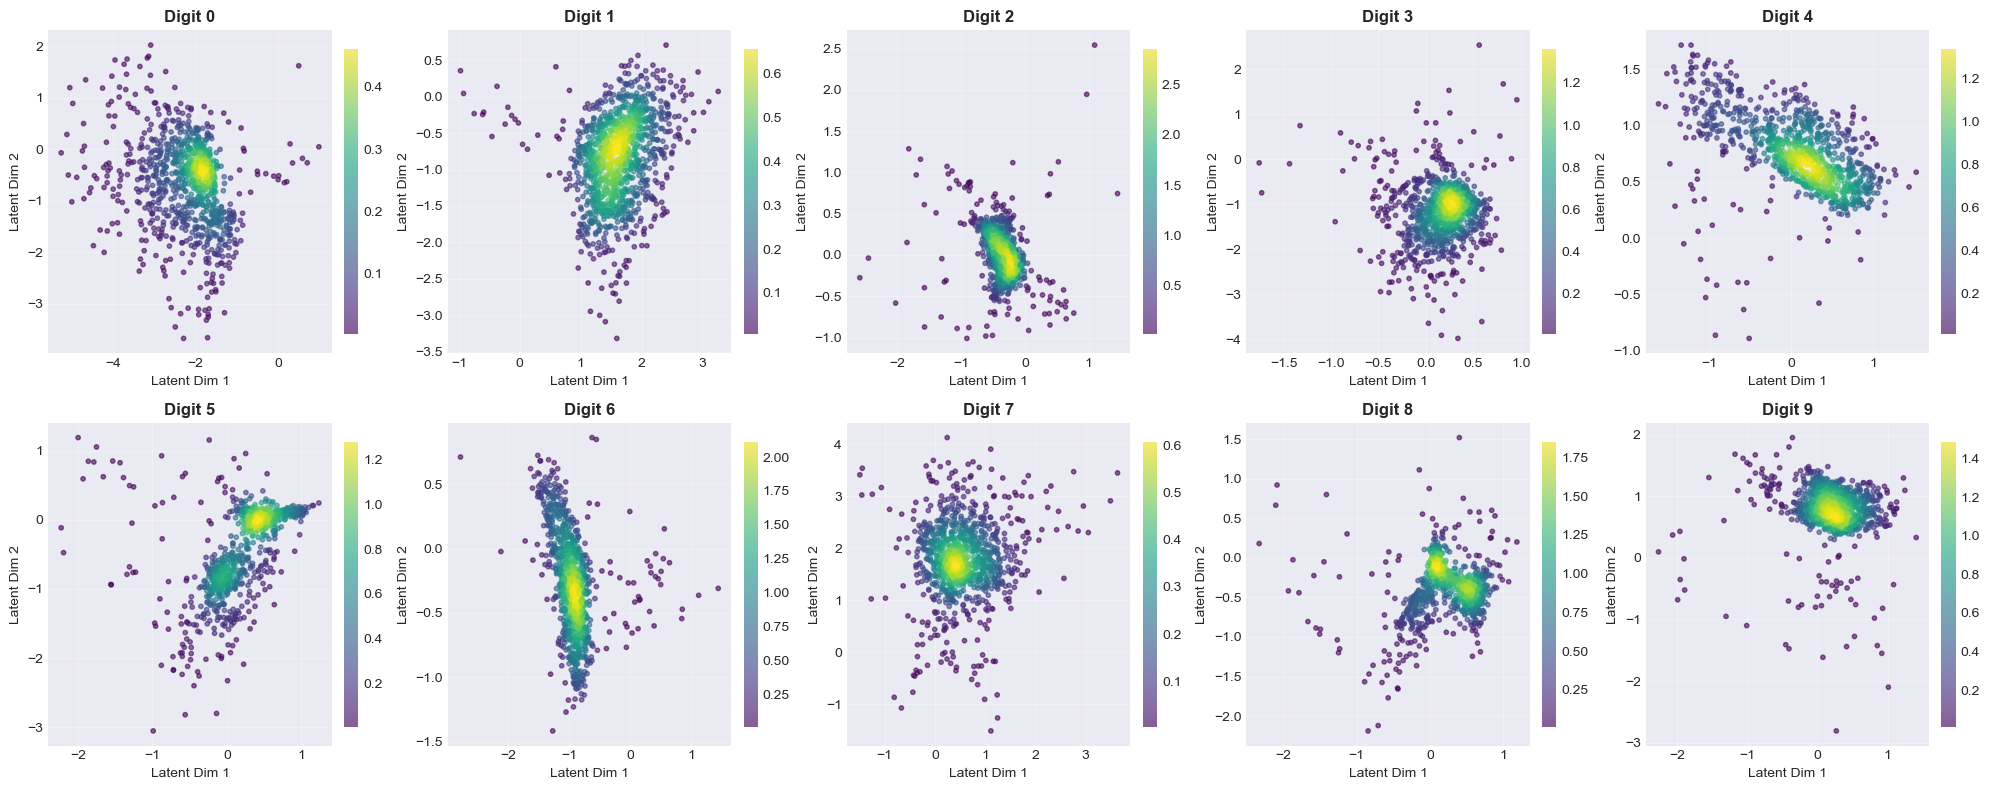


FINAL PERFORMANCE SUMMARY

📊 GENERATIVE MODEL METRICS:
  Final Training Loss: 139.4914
  Final Test Loss: 141.0123
  Reconstruction Loss: 132.7683
  KL Divergence: 6.7230

🖼️  RECONSTRUCTION QUALITY:
  SSIM: 0.5846 ± 0.1620
  PSNR: 14.96 ± 2.84 dB
  MSE: 0.037596 ± 0.018532

🎯 CLASSIFICATION METRICS (Latent Space):
  Accuracy: 0.8023
  Precision: 0.8031
  Recall: 0.8023
  F1-Score: 0.8023
  Micro-average ROC-AUC: 0.9665

✓ Training and evaluation complete!

✓ Model saved as 'vae_mnist_model.pth'


In [35]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"\nROC-AUC Scores per class:")
for i in range(10):
    print(f"Digit {i}: {roc_auc[i]:.4f}")
print(f"Micro-average ROC-AUC: {roc_auc['micro']:.4f}")

# Reconstruction quality metrics
print("\n" + "="*50)
print("COMPUTING RECONSTRUCTION QUALITY METRICS")
print("="*50)

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def compute_image_metrics(original, reconstructed):
    """
    original: numpy array. Could be shape (N, 1, 28, 28) or (N, 784)
    reconstructed: numpy array. shape (N, 784) or (N, 1, 28, 28)
    """
    ssim_scores = []
    psnr_scores = []
    mse_scores = []
    
    N = original.shape[0]
    for i in range(N):
        # get original as 2D array
        if original.ndim == 4:  # (N,1,28,28)
            orig = original[i, 0]
        elif original.ndim == 2:  # (N,784)
            orig = original[i].reshape(28, 28)
        else:
            orig = np.squeeze(original[i])
            if orig.size == 784:
                orig = orig.reshape(28, 28)
        
        # get reconstructed as 2D array
        if reconstructed.ndim == 4:
            recon = reconstructed[i, 0]
        elif reconstructed.ndim == 2:
            recon = reconstructed[i].reshape(28, 28)
        else:
            recon = np.squeeze(reconstructed[i])
            if recon.size == 784:
                recon = recon.reshape(28, 28)
        
        ssim_val = ssim(orig, recon, data_range=1.0)
        psnr_val = psnr(orig, recon, data_range=1.0)
        mse_val = np.mean((orig - recon) ** 2)
        
        ssim_scores.append(ssim_val)
        psnr_scores.append(psnr_val)
        mse_scores.append(mse_val)
    
    return np.array(ssim_scores), np.array(psnr_scores), np.array(mse_scores)

sample_size = 1000
sample_data = []
with torch.no_grad():
    for data, _ in test_loader:
        sample_data.append(data)
        if len(torch.cat(sample_data)) >= sample_size:
            break

sample_data = torch.cat(sample_data)[:sample_size].to(device)
with torch.no_grad():
    reconstructed, _, _ = model(sample_data)

# Convert to numpy for metrics
original_np = sample_data.cpu().numpy()                # shape (N,1,28,28)
reconstructed_np = reconstructed.detach().cpu().numpy()# shape (N,784)

ssim_scores, psnr_scores, mse_scores = compute_image_metrics(original_np, reconstructed_np)

print(f"SSIM: {np.mean(ssim_scores):.4f} ± {np.std(ssim_scores):.4f}")
print(f"PSNR: {np.mean(psnr_scores):.2f} ± {np.std(psnr_scores):.2f} dB")
print(f"MSE: {np.mean(mse_scores):.6f} ± {np.std(mse_scores):.6f}")

# VISUALIZATION
print("\n" + "="*50)
print("GENERATING VISUALIZATIONS")
print("="*50)

plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(18, 24))

ax1 = plt.subplot(5, 3, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Training & Test Loss', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

ax2 = plt.subplot(5, 3, 2)
plt.plot(recon_losses, label='Reconstruction Loss', linewidth=2)
plt.plot(kl_losses, label='KL Divergence', linewidth=2)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Reconstruction Loss & KL Divergence', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

ax3 = plt.subplot(5, 3, 3)
scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], 
                     c=true_labels, cmap='tab10', alpha=0.6, s=2)
plt.colorbar(scatter, label='Digit', fraction=0.046, pad=0.04)
plt.xlabel('Latent Dimension 1', fontsize=10)
plt.ylabel('Latent Dimension 2', fontsize=10)
plt.title('2D Latent Space Visualization', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

n_display = 5
sample_indices = np.random.choice(len(original_np), n_display, replace=False)

for i in range(n_display):
    ax = plt.subplot(5, 3, 4 + i)  # 4,5,6,7,8
    if i == 0:
        plt.ylabel('Original', fontsize=10)
    img = original_np[sample_indices[i], 0]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Sample {i+1}', fontsize=9)

for i in range(n_display):
    ax = plt.subplot(5, 3, 9 + i)  # 9,10,11,12,13
    if i == 0:
        plt.ylabel('Reconstructed', fontsize=10)
    img = reconstructed_np[sample_indices[i]].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

ax9 = plt.subplot(5, 3, 14)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar_kws={'shrink': 0.8}, ax=ax9)
ax9.set_xlabel('Predicted', fontsize=10)
ax9.set_ylabel('True', fontsize=10)
ax9.set_title('Confusion Matrix', fontsize=12, fontweight='bold')

ax10 = plt.subplot(5, 3, 15)
for i in range(10):
    ax10.plot(fpr[i], tpr[i], label=f'{i} (AUC={roc_auc[i]:.2f})', alpha=0.6)
ax10.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax10.set_xlabel('False Positive Rate', fontsize=9)
ax10.set_ylabel('True Positive Rate', fontsize=9)
ax10.set_title('ROC Curves (Multi-class)', fontsize=11)
ax10.legend(loc='lower right', fontsize=6)
ax10.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vae_mnist_complete_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'vae_mnist_complete_analysis.png'")
plt.show()

fig_gen = plt.figure(figsize=(6, 6))
with torch.no_grad():
    z_sample = torch.randn(25, LATENT_DIM).to(device)
    generated = model.decode(z_sample).cpu().numpy()

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(generated[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Generated Samples from Random Latent Vectors', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('generated_samples.png', dpi=150, bbox_inches='tight')
plt.close()
print("✓ Generated samples saved as 'generated_samples.png'")


idx1, idx2 = np.random.choice(len(latent_vectors), 2, replace=False)
z1 = torch.tensor(latent_vectors[idx1]).float().to(device)
z2 = torch.tensor(latent_vectors[idx2]).float().to(device)

n_steps = 10
interpolation = []
with torch.no_grad():
    for alpha in np.linspace(0, 1, n_steps):
        z_interp = (1 - alpha) * z1 + alpha * z2
        decoded = model.decode(z_interp.unsqueeze(0))
        interpolation.append(decoded.cpu().numpy())

fig_interp = plt.figure(figsize=(n_steps * 1.2, 2.2))
for i in range(n_steps):
    ax = plt.subplot(1, n_steps, i + 1)
    plt.imshow(interpolation[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_ylabel('Interpolation', fontsize=8)
    ax.set_title(f'{i/(n_steps-1):.2f}', fontsize=8)
plt.suptitle('Latent Space Interpolation', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('interpolation.png', dpi=150, bbox_inches='tight')
plt.close()
print("✓ Interpolation saved as 'interpolation.png'")

fig_ssim = plt.figure(figsize=(6, 4))
plt.hist(ssim_scores, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('SSIM Score', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title(f'SSIM Distribution (μ={np.mean(ssim_scores):.3f})', fontsize=11, fontweight='bold')
plt.axvline(np.mean(ssim_scores), color='red', linestyle='--', linewidth=1.5, label='Mean')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ssim_distribution.png', dpi=150)
plt.close()

fig_psnr = plt.figure(figsize=(6, 4))
plt.hist(psnr_scores, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('PSNR (dB)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title(f'PSNR Distribution (μ={np.mean(psnr_scores):.1f} dB)', fontsize=11, fontweight='bold')
plt.axvline(np.mean(psnr_scores), color='red', linestyle='--', linewidth=1.5, label='Mean')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('psnr_distribution.png', dpi=150)
plt.close()

print("\n✓ Reconstruction quality distributions saved as 'ssim_distribution.png' and 'psnr_distribution.png'")

print("\n" + "="*50)
print("LATENT SPACE ANALYSIS PER DIGIT")
print("="*50)

fig2, axes = plt.subplots(2, 5, figsize=(20, 8))
for digit in range(10):
    ax = axes[digit // 5, digit % 5]
    digit_latents = latent_vectors[true_labels == digit]
    
    if len(digit_latents) > 10:
        xy = np.vstack([digit_latents[:, 0], digit_latents[:, 1]])
        try:
            z = gaussian_kde(xy)(xy)
            scatter = ax.scatter(digit_latents[:, 0], digit_latents[:, 1], 
                               c=z, s=10, cmap='viridis', alpha=0.6)
            plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
        except Exception:
            # fallback scatter if KDE fails
            ax.scatter(digit_latents[:, 0], digit_latents[:, 1], s=10, alpha=0.6)
    
    ax.set_title(f'Digit {digit}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Latent Dim 1', fontsize=10)
    ax.set_ylabel('Latent Dim 2', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('latent_space_per_digit.png', dpi=300, bbox_inches='tight')
print("✓ Per-digit latent space saved as 'latent_space_per_digit.png'")
plt.show()

print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70)
print("\n📊 GENERATIVE MODEL METRICS:")
print(f"  Final Training Loss: {train_losses[-1]:.4f}")
print(f"  Final Test Loss: {test_losses[-1]:.4f}")
print(f"  Reconstruction Loss: {recon_losses[-1]:.4f}")
print(f"  KL Divergence: {kl_losses[-1]:.4f}")

print("\n🖼️  RECONSTRUCTION QUALITY:")
print(f"  SSIM: {np.mean(ssim_scores):.4f} ± {np.std(ssim_scores):.4f}")
print(f"  PSNR: {np.mean(psnr_scores):.2f} ± {np.std(psnr_scores):.2f} dB")
print(f"  MSE: {np.mean(mse_scores):.6f} ± {np.std(mse_scores):.6f}")

print("\n🎯 CLASSIFICATION METRICS (Latent Space):")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Micro-average ROC-AUC: {roc_auc['micro']:.4f}")

print("\n" + "="*70)
print("✓ Training and evaluation complete!")
print("="*70)

torch.save(model.state_dict(), 'vae_mnist_model.pth')
print("\n✓ Model saved as 'vae_mnist_model.pth'")
